In [1]:
# Purpose:  Apply previously saved featurizers and classifiers to predict candidate-sentiment for an 
#           independently-selected, manually-labeled test set.  
#           Use the classifier to predict both class (pos/neg) and class confidence. 
#           Tweets with low class confidence may be considered neutral if it improves performance. Evaluate
#           and graph performance and support for various confidence thresholds.
# Author:  Carol Sniegoski
# Date:  05/24/16
# Course:  MAS DSE capstone, Spring 2016

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import math

pd.set_option('display.max_colwidth', 240)
pd.set_option('display.max_columns', 50)

import sys
import os
import time
import datetime

from sklearn.externals import joblib

from sklearn.preprocessing import normalize

from sklearn.feature_extraction.text import TfidfVectorizer  # for featurizing using term frequencies
from sklearn.feature_extraction.text import CountVectorizer  # for featurizing using word n-grams

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier

#from textblob import TextBlob
#from textblob import Blobber
#from textblob.taggers import NLTKTagger
#from textblob.sentiments import NaiveBayesAnalyzer

print 'done'

done


In [3]:
# Function defs.

# return string with non-ascii chars removed
def to_ascii(s):
    returnstr = s.strip()
    returnstr = "".join([ch for ch in returnstr if ord(ch)< 128])
    return returnstr

# Return df containing 'fraction' fraction of the original df,
# with each value in column 'col' equally represented.
def sample_equally( df, col, fraction ):
    n = int(df.shape[0] * fraction)  # Get the total number of records to sample.
    vals = pd.unique(df[col].values.ravel())  # Get the class labels.
    n_to_sample = int(n/len(vals))   # Get the number of records to sample from each class.
    
    samples = []
    for val in vals:
        #samples.append( df[df[col]==val].sample(n=n_to_sample) )  # This should work in python 0.16.1
        rows = np.random.choice(df[df[col]==val].index.values, n_to_sample)
        sampled_df = df.ix[rows]
        samples.append(sampled_df)
    
    result = pd.concat(samples)

    return result

# Split dataframe into test/train set and validation set.
# Return tuple of ( train/test df, validation df ).
def get_validation_splits(df, label_field, validation_size=0.3):
    sss = StratifiedShuffleSplit(df[label_field], 1, validation_size, random_state=0)
    print len(sss)

    for train_index, test_index in sss:
        print len(train_index), len(test_index)
        print("TRAIN:", train_index, "TEST:", test_index)
        #df_trainTest, df_validate = df.ix[train_index], df.ix[test_index]
        #df_trainTest, df_validate = df.loc[train_index], df.loc[test_index]
        df_trainTest, df_validate = df.iloc[train_index], df.iloc[test_index]

        #print df_trainTest, df_validate

    return df_trainTest, df_validate

# From newer version of python.
def cohen_kappa_score(y1, y2, labels=None, weights=None):
    confusion = confusion_matrix(y1, y2, labels=labels)
    n_classes = confusion.shape[0]
    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)

    if weights is None:
        w_mat = np.ones([n_classes, n_classes], dtype=np.int)
        w_mat.flat[:: n_classes + 1] = 0
    elif weights == "linear" or weights == "quadratic":
        w_mat = np.zeros([n_classes, n_classes], dtype=np.int)
        w_mat += np.arange(n_classes)
        if weights == "linear":
            w_mat = np.abs(w_mat - w_mat.T)
        else:
            w_mat = (w_mat - w_mat.T) ** 2
    else:
        raise ValueError("Unknown kappa weighting type.")

    k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
    return 1 - k

print 'done'

done


In [4]:
# Locate the validation data.
%ls ../data/candidatesentiment/

20151013.csv
2016211.csv
ML_tagged/
candidatesentiment_fromDebbie_05-14-16.csv
candidatesentiment_fromDebbie_05-17-16.csv
candidatesentiment_validationSet_random_05-19-16.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16.bak.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16_2.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16_2_LinearSVC_char3and4grams_predicted.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16_2_Logistic_huberLossL2_termFrequency_predicted.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16_2_predicted.csv
candidatesentiment_validationSet_random_caslabeled_05-21-16_2_predicted_termFrequency_MultinomialNB.csv
sentimentsamples_random_05-18-16.csv


In [5]:
# Set the names of the cleaned text field and the class label field,
# to be used in the sampling, featurizing, and classification steps.
clean_text = 'ascii_clean'  # This is where the cleaned text will be put.
label_field = 'label' # This is where the labels will be put.

print 'done'

done


In [6]:
# Load data file.

prefix = "../data/candidatesentiment/"
filename = "candidatesentiment_validationSet_random_caslabeled_05-20-16_2"

#columns = ["candidate", "sentiment", "id_str", "text"]
columns = ["partition", "candidate", "text", "sentiment", "neutral"]

df = pd.read_csv(prefix + filename + '.csv', header=None, names=columns)
print df.shape
print df.columns.values
df.head(2)

(1840, 5)
['partition' 'candidate' 'text' 'sentiment' 'neutral']


,partition,candidate,text,sentiment,neutral
0,2015_10_11,Clinton,"""Black Lives Matter activists disappointed by Hillary Clinton's understanding of police violence http://t.co/BMHx8KOthY via @dailykos """,neg,NaN
1,2015_10_11,Clinton,"""@SonofLiberty357 Damn right. It should be the 1st question posed to @HillaryClinton on Tue. They'd ask #Trump2016 https://t.co/uioVhgJbXx """,neg,NaN


In [8]:
# Populate the label_field.
df[label_field] = df['candidate'] + '_' + df['sentiment']

# Show the class frequencies.
counts = df[label_field].value_counts()
total = counts.sum()

counts = counts.apply(lambda x: ("Count: %d" % x, "Frequency: %.2f" % (float(x)/total)) )

#print("%.2f" % a)
#string = 'string%d' % (i,)

print counts
print type(counts)
print df.shape

Sanders_pos    (Count: 269, Frequency: 0.15)
Clinton_neg    (Count: 236, Frequency: 0.13)
Rubio_neg      (Count: 227, Frequency: 0.12)
Trump_neg      (Count: 200, Frequency: 0.11)
Cruz_neg       (Count: 189, Frequency: 0.10)
Cruz_pos       (Count: 177, Frequency: 0.10)
Trump_pos      (Count: 162, Frequency: 0.09)
Clinton_pos    (Count: 142, Frequency: 0.08)
Rubio_pos      (Count: 135, Frequency: 0.07)
Sanders_neg    (Count: 103, Frequency: 0.06)
dtype: object
<class 'pandas.core.series.Series'>
(1840, 6)


In [9]:
# Clean the 'text' field.

# Convert to ascii
df['ascii'] = df['text'].apply(to_ascii)
df[clean_text] = df['ascii']

# Remove hashtags
#df[clean_text] = df[clean_text].str.replace(r"#([A-Za-z0-9_]+)", " ")

# Remove handles
#df[clean_text] = df[clean_text].str.replace(r"@([A-Za-z0-9_]+)", " ")

# Remove URLs
#df[clean_text] = df[clean_text].str.replace(r"http([A-Za-z0-9_:.\/]+)", " ")
# Replace URLs with "URL"
df[clean_text] = df[clean_text].str.replace(r"http([A-Za-z0-9_:.\/]+)", "URL")

# Remove punctuation symbols - but not @ or #
df[clean_text] = df[clean_text].str.replace(r"(['';:%()\+\*\"\…\“\”])", "")
#df[clean_text] = df[clean_text].str.replace(r"(['';:@%#()\+\*\"\…\“\”])", "")
#df[clean_text] = df[clean_text].str.replace(r"([;:@%#()\+\*\"\…\“\”])", "")
df[clean_text] = df[clean_text].str.replace(r"([.-])", " ")

# Remove eol symbols
df[clean_text] = df[clean_text].str.replace(r"\n", " ")

# Remove &x symbols
df[clean_text] = df[clean_text].str.replace(r"&[a-z]+", " ")

# Convert to lowercase
df[clean_text] = df[clean_text].str.lower()

#print df[df['ascii']!=df[clean_text]][['ascii', 'K_sentiment']].head(10)
df[['text', clean_text]].head(3)
#df[df['ascii'].str.contains("\n")][['text', 'ascii']].head(10)

,text,ascii_clean
0,"""Black Lives Matter activists disappointed by Hillary Clinton's understanding of police violence http://t.co/BMHx8KOthY via @dailykos """,black lives matter activists disappointed by hillary clintons understanding of police violence url via @dailykos
1,"""@SonofLiberty357 Damn right. It should be the 1st question posed to @HillaryClinton on Tue. They'd ask #Trump2016 https://t.co/uioVhgJbXx """,@sonofliberty357 damn right it should be the 1st question posed to @hillaryclinton on tue theyd ask #trump2016 url
2,"""the black lives matter protestors should go after hilary ... bill clinton did more to increase prison population than any1 in modern history """,the black lives matter protestors should go after hilary bill clinton did more to increase prison population than any1 in modern history


In [10]:
# Locate the featurizers and classifiers.
%ls ../classification/candidatesentiment/

LinearSVC_char3and4grams_Clinton_05-21-16.pkl                   Logistic_regular_termFrequency_Cruz_05-22-16.pkl_03.npy
LinearSVC_char3and4grams_Clinton_05-21-16.pkl_01.npy            Logistic_regular_termFrequency_Cruz_Deb-05-22-16.pkl
LinearSVC_char3and4grams_Clinton_05-21-16.pkl_02.npy            Logistic_regular_termFrequency_Cruz_Deb-05-22-16.pkl_01.npy
LinearSVC_char3and4grams_Clinton_05-25-16.pkl                   Logistic_regular_termFrequency_Cruz_Deb-05-22-16.pkl_02.npy
LinearSVC_char3and4grams_Cruz_05-21-16.pkl                      Logistic_regular_termFrequency_Cruz_Deb-05-22-16.pkl_03.npy
LinearSVC_char3and4grams_Cruz_05-21-16.pkl_01.npy               Logistic_regular_termFrequency_Rubio_05-22-16.pkl
LinearSVC_char3and4grams_Cruz_05-21-16.pkl_02.npy               Logistic_regular_termFrequency_Rubio_05-22-16.pkl_01.npy
LinearSVC_char3and4grams_Cruz_05-25-16.pkl                      Logistic_regular_termFrequency_Rubio_05-22-16.pkl_02.npy
LinearSVC_char3and4grams_Rubio_05-2

In [11]:
### BEST SO FAR
prefix = "../classification/candidatesentiment/"
feature_type = "char3and4grams"
classifier_type = "LinearSVC"
date_created = "05-21-16"
candidates = ['Trump', 'Clinton', 'Sanders', 'Rubio', 'Cruz']
print candidates, feature_type, classifier_type

['Trump', 'Clinton', 'Sanders', 'Rubio', 'Cruz'] char3and4grams LinearSVC


In [10]:
prefix = "../classification/candidatesentiment/"
feature_type = "termFrequency"
classifier_type = "Logistic_huberLossL2"
date_created = "05-24-16"
candidates = ['Trump', 'Clinton', 'Sanders', 'Rubio', 'Cruz']
print candidates, feature_type, classifier_type

['Trump', 'Clinton', 'Sanders', 'Rubio', 'Cruz'] termFrequency Logistic_huberLossL2


In [11]:
# Locaate outoput directory for labeled data.
%ls ../data/candidatesentiment/

ML_tagged/
candidatesentiment_fromDebbie_05-14-16.csv
candidatesentiment_fromDebbie_05-17-16.csv
candidatesentiment_validationSet_random_05-19-16.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16.bak.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16_2.csv
candidatesentiment_validationSet_random_caslabeled_05-20-16_2_predicted.csv
candidatesentiment_validationSet_random_caslabeled_05-21-16_2_predicted_termFrequency_MultinomialNB.csv
sentimentsamples_random_05-18-16.csv


In [58]:
outfile = '../data/candidatesentiment/' + filename + '_' + classifier_type + '_' + feature_type + '_predicted.csv'
print outfile

../data/candidatesentiment/candidatesentiment_validationSet_random_caslabeled_05-20-16_2_LinearSVC_char3and4grams_predicted.csv


In [30]:
# Load featurizers and classifiers.
# For each candidate, use the featurizer to transform the validation data, apply the classifier to it, 
# and write class and class confidence predictions to file.

with open(outfile, 'a') as f:
    for candidate in candidates:
        print candidate
    
        # Get data for this candidate.
        #candidate_df = df[ df['candidate']==candidate ]
        candidate_df = df[ df['candidate']==candidate ].copy(deep=True)
    
        # Load and apply featurizer.
        
        #my_classifier = joblib.load( 'classifier_filename.pkl' )
        #my_featurizer = joblib.load('featurizer_filename.pkl')
        featurizer_name = feature_type + '_' + candidate + '_' + date_created + '.pkl'
        print "Loading featurizer: " + prefix + featurizer_name
        featurizer = joblib.load( prefix + featurizer_name )
        
        #print 'Applying featurizer to validation data ...'
        X = featurizer.transform(candidate_df[clean_text])
        #print 'Done applying featurizer to validation data.'
    
        # Load and apply classifier.
        
        classifier_name = classifier_type + '_' + feature_type + '_' + candidate + '_' + date_created + '.pkl'
        print "Loading classifier: " + prefix + classifier_name
        classifier = joblib.load( prefix + classifier_name )
        
        #print 'Applying classifier to featurized validation data ...'
        y = candidate_df[label_field].values
        y_pred = classifier.predict(X)
        print len(y_pred)
        # Get decision function values. These range from below 0 to above 0.
        y_confidence = classifier.decision_function(X)
        # Get list of p(pos) values. These range from 0 to 1.
        #y_confidence = [p[1] for p in classifier.predict_proba(X)]
        
        y_conf_mean = np.mean(y_confidence)
        y_conf_var = np.var(y_confidence)
        y_confidence_normalized = map(lambda x: (x-y_conf_mean)/y_conf_var, y_confidence)
        
        #y = candidate_df[label_field].values
        #print min(y_confidence), max(y_confidence)
        
        #print 'Done applying classifier to featurized validation data.'

        #candidate_df["predicted"] = y_pred
        #candidate_df["confidence"] = y_confidence
        neg_min = (-1000)
        neu_min = (-1.5)
        pos_min = (1.5)
        neu_min_norm = (-.085)
        pos_min_norm = (.085)
        max_val = (1000)
        
        # Use for probablilities.
        #neg_min = (-0.1)
        #neu_min = (0.4)
        #pos_min = (0.57)
        #max_val = (1.1)
        
        y_3way_pred = pd.cut( y_confidence, [neg_min, neu_min, pos_min, max_val], 
                                                labels=[ candidate+'_neg', candidate+'_neu', candidate+'_pos' ] )
        y_3way_pred_norm = pd.cut( y_confidence_normalized, [neg_min, neu_min_norm, pos_min_norm, max_val], 
                                                labels=[ candidate+'_neg', candidate+'_neu', candidate+'_pos' ] )

        #ids, other = zip(*((id, other) for id, other in zip(ids, other) if id not in del_ids))
        y_relaxed, y_relaxed_pred = zip(*((y1, y2) for y1, y2 in zip(y, y_3way_pred) if y2 in 
                                         [candidate+'_neg', candidate+'_pos']))
        y_relaxed_norm, y_relaxed_pred_norm = zip(*((y1, y2) for y1, y2 in zip(y, y_3way_pred_norm) if y2 in 
                                         [candidate+'_neg', candidate+'_pos']))
    
        # Append results to csv file.
        #candidate_df['predicted'] = y_3way_pred
        #candidate_df.to_csv(f, header=None)
        
        # Print metrics
        #y = candidate_df[label_field].values
        #print y[0], y_pred[0]
        #print confusion_matrix( y, y_pred )
        #print confusion_matrix( y_relaxed, y_relaxed_pred )
        print classification_report( y, y_pred )
        print classification_report( y_relaxed, y_relaxed_pred )
        print classification_report( y_relaxed_norm, y_relaxed_pred_norm )
        print metrics.accuracy_score( y, y_pred )
        print metrics.accuracy_score( y_relaxed, y_relaxed_pred )
        print metrics.accuracy_score( y_relaxed_norm, y_relaxed_pred_norm )
        print metrics.precision_score( y, y_pred, pos_label=candidate+'_pos' )

f.close()

print 'done'


Trump
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Trump_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3and4grams_Trump_05-21-16.pkl
362
             precision    recall  f1-score   support

  Trump_neg       0.72      0.71      0.72       200
  Trump_pos       0.65      0.67      0.66       162

avg / total       0.69      0.69      0.69       362

             precision    recall  f1-score   support

  Trump_neg       0.84      0.73      0.78        99
  Trump_pos       0.69      0.81      0.74        73

avg / total       0.77      0.76      0.76       172

             precision    recall  f1-score   support

  Trump_neg       0.75      0.72      0.74       174
  Trump_pos       0.66      0.70      0.68       137

avg / total       0.71      0.71      0.71       311

0.690607734807
0.761627906977
0.710610932476
0.650602409639
Clinton
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Clinton_05-21

termFrequency, MultinomialNB

Trump
Loading featurizer: ../classification/candidatesentiment/termFrequency_Trump_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/MultinomialNB_termFrequency_Trump_05-21-16.pkl
[[147  53]
 [ 51 111]]
             precision    recall  f1-score   support

  Trump_neg       0.74      0.73      0.74       200
  Trump_pos       0.68      0.69      0.68       162

avg / total       0.71      0.71      0.71       362

0.71270718232
Clinton
Loading featurizer: ../classification/candidatesentiment/termFrequency_Clinton_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/MultinomialNB_termFrequency_Clinton_05-21-16.pkl
[[183  53]
 [ 58  84]]
             precision    recall  f1-score   support

Clinton_neg       0.76      0.78      0.77       236
Clinton_pos       0.61      0.59      0.60       142

avg / total       0.70      0.71      0.71       378

0.706349206349
Sanders
Loading featurizer: ../classification/candidatesentiment/termFrequency_Sanders_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/MultinomialNB_termFrequency_Sanders_05-21-16.pkl
[[ 70  33]
 [ 68 201]]
             precision    recall  f1-score   support

Sanders_neg       0.51      0.68      0.58       103
Sanders_pos       0.86      0.75      0.80       269

avg / total       0.76      0.73      0.74       372

0.728494623656
Rubio
Loading featurizer: ../classification/candidatesentiment/termFrequency_Rubio_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/MultinomialNB_termFrequency_Rubio_05-21-16.pkl
[[172  55]
 [ 48  87]]
             precision    recall  f1-score   support

  Rubio_neg       0.78      0.76      0.77       227
  Rubio_pos       0.61      0.64      0.63       135

avg / total       0.72      0.72      0.72       362

0.71546961326
Cruz
Loading featurizer: ../classification/candidatesentiment/termFrequency_Cruz_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/MultinomialNB_termFrequency_Cruz_05-21-16.pkl
[[163  26]
 [ 44 133]]
             precision    recall  f1-score   support

   Cruz_neg       0.79      0.86      0.82       189
   Cruz_pos       0.84      0.75      0.79       177

avg / total       0.81      0.81      0.81       366

0.808743169399
done

In [83]:
# Use this cell to create graph of prec, recall, F-value for pos, neg, average
# and percent tweets lost for each margin tried.

# Load featurizers and classifiers.
# For each candidate, use the featurizer to transform the validation data, apply the classifier to it, 
# and write class and class confidence predictions to file.

outfile = "notafile"
relaxed_results = {}
with open(outfile, 'a') as f:
    for candidate in candidates:
        print candidate
        relaxed_results[candidate] = {}
    
        # Get data for this candidate.
        #candidate_df = df[ df['candidate']==candidate ]
        candidate_df = df[ df['candidate']==candidate ].copy(deep=True)
    
        # Load and apply featurizer.
        
        #my_classifier = joblib.load( 'classifier_filename.pkl' )
        #my_featurizer = joblib.load('featurizer_filename.pkl')
        featurizer_name = feature_type + '_' + candidate + '_' + date_created + '.pkl'
        print "Loading featurizer: " + prefix + featurizer_name
        featurizer = joblib.load( prefix + featurizer_name )
        
        #print 'Applying featurizer to validation data ...'
        X = featurizer.transform(candidate_df[clean_text])
        #print 'Done applying featurizer to validation data.'
    
        # Load and apply classifier.
        
        classifier_name = classifier_type + '_' + feature_type + '_' + candidate + '_' + date_created + '.pkl'
        print "Loading classifier: " + prefix + classifier_name
        classifier = joblib.load( prefix + classifier_name )
        
        #print 'Applying classifier to featurized validation data ...'
        y = candidate_df[label_field].values
        y_pred = classifier.predict(X)
        print len(y_pred)
        # Get decision function values. These range from below 0 to above 0.
        y_confidence = classifier.decision_function(X)
        # Get list of p(pos) values. These range from 0 to 1.
        #y_confidence = [p[1] for p in classifier.predict_proba(X)]
        
        y_conf_mean = np.mean(y_confidence)
        y_conf_var = np.var(y_confidence)
        y_confidence_normalized = map(lambda x: (x-y_conf_mean)/y_conf_var, y_confidence)
        
        #y = candidate_df[label_field].values
        #print min(y_confidence), max(y_confidence)
        
        #print 'Done applying classifier to featurized validation data.'
        
        #candidate_df["predicted"] = y_pred
        #candidate_df["confidence"] = y_confidence
        neg_min = (-1000)
        max_val = (1000)

        step = 1.5
        relaxed_results[candidate]["precision"] = []
        relaxed_results[candidate]["recall"] = []
        relaxed_results[candidate]["f-score"] = []
        relaxed_results[candidate]["support"] = []
        support = len(y)

        for i in range(0,2):
            #print i*step, -i*step
            #neu_min = (-1.5)
            #pos_min = (1.5)
            neu_min = -i*step
            pos_min = i*step
        
            if (i==0):
                relaxed_results[candidate]["precision"].append(metrics.precision_score( y, y_pred,
                                                                                       pos_label=candidate+'_pos' ))
                relaxed_results[candidate]["recall"].append(metrics.recall_score( y, y_pred,
                                                                                       pos_label=candidate+'_pos' ))                
                relaxed_results[candidate]["f-score"].append(metrics.f1_score( y, y_pred,
                                                                                       pos_label=candidate+'_pos' ))
                relaxed_results[candidate]["support"].append(float(1))
                
                print "Candidate={0}, margin={1}".format(candidate, i*step)
                print classification_report( y, y_pred )
                print "Accuracy:", metrics.accuracy_score( y, y_pred )
            else:
                y_3way_pred = pd.cut( y_confidence, [neg_min, neu_min, pos_min, max_val], 
                                                    labels=[ candidate+'_neg', candidate+'_neu', candidate+'_pos' ] )
                y_relaxed, y_relaxed_pred = zip(*((y1, y2) for y1, y2 in zip(y, y_3way_pred) if y2 in 
                                                 [candidate+'_neg', candidate+'_pos']))
                relaxed_results[candidate]["precision"].append(metrics.precision_score( y_relaxed, y_relaxed_pred,
                                                                                       pos_label=candidate+'_pos'))
                relaxed_results[candidate]["recall"].append(metrics.recall_score( y_relaxed, y_relaxed_pred,
                                                                                       pos_label=candidate+'_pos'))
                relaxed_results[candidate]["f-score"].append(metrics.f1_score( y_relaxed, y_relaxed_pred,
                                                                                       pos_label=candidate+'_pos'))
                relaxed_results[candidate]["support"].append(float(len(y_relaxed))/support)

                print "Candidate={0}, margin={1}".format(candidate, i*step)
                # Print metrics
                #y = candidate_df[label_field].values
                #print y[0], y_pred[0]
                #print confusion_matrix( y, y_pred )
                #print confusion_matrix( y_relaxed, y_relaxed_pred )
                #print classification_report( y, y_pred )
                print classification_report( y_relaxed, y_relaxed_pred )
                #print metrics.accuracy_score( y, y_pred )
                print "Accuracy:", metrics.accuracy_score( y_relaxed, y_relaxed_pred )

f.close()

print 'done'
#for candidate in candidates:
#    print candidate
#    for score in ['precision', 'recall', 'f-score', 'support']:
#        print relaxed_results[candidate][score]
        

Trump
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Trump_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3and4grams_Trump_05-21-16.pkl
362
Candidate=Trump, margin=0.0
             precision    recall  f1-score   support

  Trump_neg       0.72      0.71      0.72       200
  Trump_pos       0.65      0.67      0.66       162

avg / total       0.69      0.69      0.69       362

Accuracy: 0.690607734807
Candidate=Trump, margin=1.5
             precision    recall  f1-score   support

  Trump_neg       0.84      0.73      0.78        99
  Trump_pos       0.69      0.81      0.74        73

avg / total       0.77      0.76      0.76       172

Accuracy: 0.761627906977
Clinton
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Clinton_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3and4grams_Clinton_05-21-16.pkl
378
Candidate=Clinton, margin=0.0
             precision  

Trump
[0, 0.5, 1.0, 1.5, 2.0]
Clinton
[0, 0.5, 1.0, 1.5, 2.0]
Sanders
[0, 0.5, 1.0, 1.5, 2.0]
Rubio
[0, 0.5, 1.0, 1.5, 2.0]
Cruz
[0, 0.5, 1.0, 1.5, 2.0]


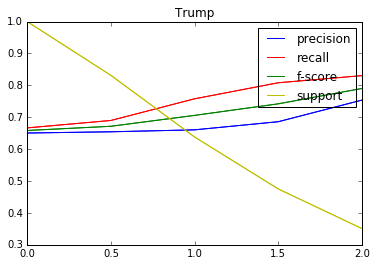

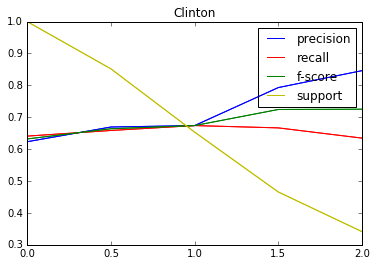

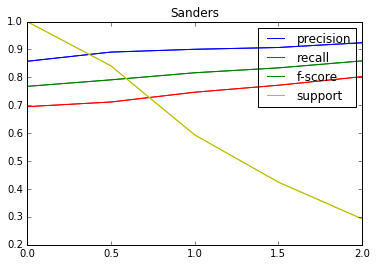

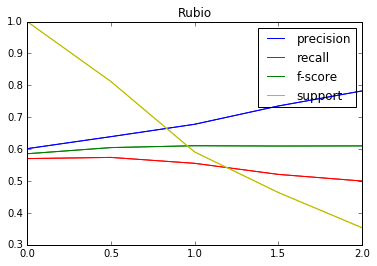

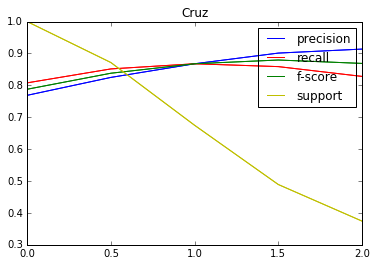

In [81]:
i = 0
for candidate in candidates:
    print candidate
    plt.figure(i)
    plt.title(candidate )
    #x = np.arange(0, len(relaxed_results[candidate]['precision'])/2, step)
    #x = np.arange(0, len(relaxed_results[candidate]['precision']))
    x = [0, .5, 1.0, 1.5, 2.0]
    print x
    #np.arange(0, 5, 0.1)
    colors = ['-b', '-r', '-g', '-y']
    #for score in ['precision', 'recall', 'f-score', 'support']:
    for score, color in zip(['precision', 'recall', 'f-score', 'support'], colors):
        #print relaxed_results[candidate][score]    
        #y = centroids[centroids_ix][i]
        y = relaxed_results[candidate][score] 
    
        #ax = plt.subplot(3,4,i+1)
        #ax.set_xticks(my_features)
        #plt.xticks(range(0, len(y)), cluster_features, size='small', rotation=45)
        
        plt.plot(x, y, color, label=score)
        plt.legend(loc='upper right')
        #pylab.plot(x, y1, '-b', label='sine')
        #pylab.plot(x, y2, '-r', label='cosine')
        #pylab.legend(loc='upper left')
        #pylab.ylim(-1.5, 2.0)
        #pylab.show()
        plt.locator_params(axis='x',nbins=4)
        plt.plot(x, y, color)
    i+=1

In [62]:
step = 0.5
for i in range(6):
    print i*step, -i*step
print 'done'

0.0 0.0
0.5 -0.5
1.0 -1.0
1.5 -1.5
2.0 -2.0
2.5 -2.5
done


In [32]:
my_ndarray = np.array([1,2,3, 4, 5, 6])
print my_ndarray
print min(my_ndarray)
print np.var(my_ndarray)
my_var = np.var(my_ndarray)
my_mean = np.mean(my_ndarray)
print map(lambda x: (x-my_mean)/my_var, my_ndarray)


[1 2 3 4 5 6]
1
2.91666666667
[-0.85714285714285721, -0.51428571428571435, -0.17142857142857143, 0.17142857142857143, 0.51428571428571435, 0.85714285714285721]


char3grams, LinearSVC



char3and4grams, LinearSVC

Trump
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Trump_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3and4grams_Trump_05-21-16.pkl
[[142  58]
 [ 54 108]]
             precision    recall  f1-score   support

  Trump_neg       0.72      0.71      0.72       200
  Trump_pos       0.65      0.67      0.66       162

avg / total       0.69      0.69      0.69       362

0.690607734807
Clinton
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Clinton_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3and4grams_Clinton_05-21-16.pkl
[[181  55]
 [ 51  91]]
             precision    recall  f1-score   support

Clinton_neg       0.78      0.77      0.77       236
Clinton_pos       0.62      0.64      0.63       142

avg / total       0.72      0.72      0.72       378

0.719576719577
Sanders
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Sanders_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3and4grams_Sanders_05-21-16.pkl
[[ 72  31]
 [ 82 187]]
             precision    recall  f1-score   support

Sanders_neg       0.47      0.70      0.56       103
Sanders_pos       0.86      0.70      0.77       269

avg / total       0.75      0.70      0.71       372

0.69623655914
Rubio
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Rubio_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3and4grams_Rubio_05-21-16.pkl
[[176  51]
 [ 58  77]]
             precision    recall  f1-score   support

  Rubio_neg       0.75      0.78      0.76       227
  Rubio_pos       0.60      0.57      0.59       135

avg / total       0.70      0.70      0.70       362

0.698895027624
Cruz
Loading featurizer: ../classification/candidatesentiment/char3and4grams_Cruz_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3and4grams_Cruz_05-21-16.pkl
[[146  43]
 [ 34 143]]
             precision    recall  f1-score   support

   Cruz_neg       0.81      0.77      0.79       189
   Cruz_pos       0.77      0.81      0.79       177

avg / total       0.79      0.79      0.79       366

0.789617486339
done

termFrequency, LinearSVC




char3grams, Logistic

Trump
Loading featurizer: ../classification/candidatesentiment/char3grams_Trump_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/Logistic_char3grams_Trump_05-21-16.pkl
[[155  45]
 [ 64  98]]
             precision    recall  f1-score   support

  Trump_neg       0.71      0.78      0.74       200
  Trump_pos       0.69      0.60      0.64       162

avg / total       0.70      0.70      0.70       362

0.698895027624
Clinton
Loading featurizer: ../classification/candidatesentiment/char3grams_Clinton_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/Logistic_char3grams_Clinton_05-21-16.pkl
[[173  63]
 [ 52  90]]
             precision    recall  f1-score   support

Clinton_neg       0.77      0.73      0.75       236
Clinton_pos       0.59      0.63      0.61       142

avg / total       0.70      0.70      0.70       378

0.695767195767
Sanders
Loading featurizer: ../classification/candidatesentiment/char3grams_Sanders_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/Logistic_char3grams_Sanders_05-21-16.pkl
[[ 72  31]
 [ 98 171]]
             precision    recall  f1-score   support

Sanders_neg       0.42      0.70      0.53       103
Sanders_pos       0.85      0.64      0.73       269

avg / total       0.73      0.65      0.67       372

0.653225806452
Rubio
Loading featurizer: ../classification/candidatesentiment/char3grams_Rubio_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/Logistic_char3grams_Rubio_05-21-16.pkl
[[177  50]
 [ 58  77]]
             precision    recall  f1-score   support

  Rubio_neg       0.75      0.78      0.77       227
  Rubio_pos       0.61      0.57      0.59       135

avg / total       0.70      0.70      0.70       362

0.701657458564
Cruz
Loading featurizer: ../classification/candidatesentiment/char3grams_Cruz_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/Logistic_char3grams_Cruz_05-21-16.pkl
[[161  28]
 [ 66 111]]
             precision    recall  f1-score   support

   Cruz_neg       0.71      0.85      0.77       189
   Cruz_pos       0.80      0.63      0.70       177

avg / total       0.75      0.74      0.74       366

0.743169398907
done

LinearSVC, char3to5grams

Trump
Loading featurizer: ../classification/candidatesentiment/char3to5grams_Trump_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3to5grams_Trump_05-21-16.pkl
[[136  64]
 [ 57 105]]
             precision    recall  f1-score   support

  Trump_neg       0.70      0.68      0.69       200
  Trump_pos       0.62      0.65      0.63       162

avg / total       0.67      0.67      0.67       362

0.665745856354
Clinton
Loading featurizer: ../classification/candidatesentiment/char3to5grams_Clinton_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3to5grams_Clinton_05-21-16.pkl
[[181  55]
 [ 51  91]]
             precision    recall  f1-score   support

Clinton_neg       0.78      0.77      0.77       236
Clinton_pos       0.62      0.64      0.63       142

avg / total       0.72      0.72      0.72       378

0.719576719577
Sanders
Loading featurizer: ../classification/candidatesentiment/char3to5grams_Sanders_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3to5grams_Sanders_05-21-16.pkl
[[ 75  28]
 [ 82 187]]
             precision    recall  f1-score   support

Sanders_neg       0.48      0.73      0.58       103
Sanders_pos       0.87      0.70      0.77       269

avg / total       0.76      0.70      0.72       372

0.704301075269
Rubio
Loading featurizer: ../classification/candidatesentiment/char3to5grams_Rubio_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3to5grams_Rubio_05-21-16.pkl
[[177  50]
 [ 53  82]]
             precision    recall  f1-score   support

  Rubio_neg       0.77      0.78      0.77       227
  Rubio_pos       0.62      0.61      0.61       135

avg / total       0.71      0.72      0.71       362

0.71546961326
Cruz
Loading featurizer: ../classification/candidatesentiment/char3to5grams_Cruz_05-21-16.pkl
Loading classifier: ../classification/candidatesentiment/LinearSVC_char3to5grams_Cruz_05-21-16.pkl
[[155  34]
 [ 42 135]]
             precision    recall  f1-score   support

   Cruz_neg       0.79      0.82      0.80       189
   Cruz_pos       0.80      0.76      0.78       177

avg / total       0.79      0.79      0.79       366

0.792349726776
done

In [46]:
# Populate the label_field.
df[label_field] = df['candidate'] + '_' + df['sentiment']

# Show the class frequencies.
counts = df[label_field].value_counts()
total = counts.sum()

counts = counts.apply(lambda x: ("Count: %d" % x, "Frequency: %.2f" % (float(x)/total)) )

#print("%.2f" % a)
#string = 'string%d' % (i,)

print counts
print type(counts)

Trump_pos      (Count: 3800, Frequency: 0.10)
Clinton_pos    (Count: 3800, Frequency: 0.10)
Sanders_pos    (Count: 3800, Frequency: 0.10)
Cruz_pos       (Count: 3800, Frequency: 0.10)
Trump_neg      (Count: 3778, Frequency: 0.10)
Clinton_neg    (Count: 3760, Frequency: 0.10)
Sanders_neg    (Count: 3665, Frequency: 0.10)
Rubio_pos      (Count: 3640, Frequency: 0.10)
Cruz_neg       (Count: 3591, Frequency: 0.10)
Rubio_neg      (Count: 3541, Frequency: 0.10)
dtype: object
<class 'pandas.core.series.Series'>


In [47]:
# Classes are balanced, so no need to under- or oversample. Just use the original unsampled data.

# True if you want to set aside a validation set upfront.
do_validation = True

df_samples = []
sample_names = []
df_validation_splits = []
    
#df_samples = [ df ]
#sample_names = [ 'original data' ]

# Treat each candidate as a separate sample.
candidates = df['candidate'].unique()
print candidates

for candidate in candidates:
    sample_df = df[ df['candidate']==candidate]
    #sample_df = df[ df['candidate']==candidate].copy(deep=True)
    #print sample_df.shape
    #print sample_df.head(3)

    if do_validation:
        print candidate
        trainTest_df, validate_df = get_validation_splits( sample_df, label_field, 0.3 )
        df_samples.append( trainTest_df )
        df_validation_splits.append( validate_df )
    else:
        #df_samples.append( df[ df['candidate']==candidate] )
        df_samples.append( sample_df )
    sample_names.append( candidate )
    #df_samples.append(sample_equally( df, label_field, data_fraction ))
    #sample_names.append( str(data_fraction)+' random sample' )

print len(df_samples), len(df_validation_splits)
print 'done'

['Trump' 'Clinton' 'Sanders' 'Cruz' 'Rubio']
Trump
1
5304 2274
('TRAIN:', array([3662, 7410, 4158, ...,   61, 2808, 3383]), 'TEST:', array([2507, 1798,  501, ..., 2504, 2853, 1772]))
Clinton
1
5292 2268
('TRAIN:', array([4184, 5847, 6911, ..., 6548,  811,  197]), 'TEST:', array([6526, 5957, 2195, ...,  431, 2285, 2916]))
Sanders
1
5225 2240
('TRAIN:', array([ 802,  581, 4581, ..., 1815, 4969, 1351]), 'TEST:', array([2507, 2963, 2850, ..., 5782, 5731, 7226]))
Cruz
1
5173 2218
('TRAIN:', array([2312, 4065, 5011, ..., 2394, 1926,  910]), 'TEST:', array([7107, 6269, 5103, ..., 1360, 1281, 4324]))
Rubio
1
5026 2155
('TRAIN:', array([4570, 2141, 1663, ..., 4579, 5911, 6046]), 'TEST:', array([ 675, 4083, 5653, ..., 7081, 2978, 6044]))
5 5
done


In [48]:
# Convert data & their class labels into ndarrays.
X_samples = []
y_samples = []

for df_sample in df_samples:
    X_samples.append(df_sample[clean_text].values)
    y_samples.append(df_sample[label_field].values)
    
if do_validation:
    X_validation_splits = []
    y_validation_splits = []
    for df_validation_split in df_validation_splits:
        X_validation_splits.append(df_validation_split[clean_text].values)
        y_validation_splits.append(df_validation_split[label_field].values)

print type(X_samples[0])
print len(X_samples)
print len(y_samples)
print X_samples[0].shape

print len(X_validation_splits)
print X_validation_splits[0].shape

<type 'numpy.ndarray'>
5
5
(5304,)
5
(2274,)


In [73]:
# Initialize list of types of feature vectors to use.
# Add feature vectors to this list by running one or more of the feature-generation cells below.

feature_vector_lists = []
feature_vector_validation_lists = []
feature_names = []
featurizers = []
print 'done'

done


In [74]:
# Create feature vectors using character n-grams.

this_feature_name = "char 3grams"
this_feature_vector_list = []
this_feature_vector_validation_list = []

ngram_min_size = 3
ngram_max_size = 3

#test_string = ["I really like python, it's pretty awesome."]
vectorizer = CountVectorizer(ngram_range=(ngram_min_size,ngram_max_size),  # use n-gram sizes from min to max, inclusive
                             min_df = 5,     # min number of docs a token must appear in
                             max_df = .8,    # max percent of docs a token can appear in
                             analyzer='char'  # create character ngrams
                             )

for X_sample, X_validation_split, sample_name in zip(X_samples, X_validation_splits, sample_names):
    this_feature_vector_list.append( vectorizer.fit_transform(X_sample) )
    this_feature_vector_validation_list.append( vectorizer.transform(X_validation_split) )
    #feature_names.append( this_feature_name + ', ' + sample_name )

feature_vector_lists.append(this_feature_vector_list)
feature_vector_validation_lists.append(this_feature_vector_validation_list)
feature_names.append(this_feature_name)

for feature_vector, sample_name in zip(this_feature_vector_list, sample_names):
    print sample_name, feature_vector.shape
print feature_names
    
#print('{1}-grams: {0}'.format(vect.get_feature_names(), ngram_size))
#print 'Number of char n-grams:', len(vectorizer.get_feature_names())
#print vectorizer.get_feature_names()[1000:1025]


Trump (5304, 5613)
Clinton (5292, 5688)
Sanders (5225, 5432)
Cruz (5173, 5497)
Rubio (5026, 5182)
['char 3grams']


In [75]:
# Create feature vectors using word n-grams.

this_feature_name = 'word 1- & 2grams'
this_feature_vector_list = []
this_feature_vector_validation_list = []

ngram_min_size = 1
ngram_max_size = 2

vectorizer = CountVectorizer(ngram_range=(ngram_min_size,ngram_max_size),  # use n-gram sizes from min to max, inclusive
                             min_df = 5,      # min number of docs a token must appear in (if an integer value)
                             max_df = 0.8,    # max percent of docs a token can appear in (if a float value)
                             analyzer='word'  # create word ngrams; this is the default
                             )

for X_sample, X_validation_split, sample_name in zip(X_samples, X_validation_splits, sample_names):
    this_feature_vector_list.append( vectorizer.fit_transform(X_sample) )
    this_feature_vector_validation_list.append( vectorizer.transform(X_validation_split) )
    #feature_names.append( this_feature_name + ', ' + sample_name )
    
feature_vector_lists.append(this_feature_vector_list)
feature_vector_validation_lists.append(this_feature_vector_validation_list)
feature_names.append(this_feature_name)

for feature_vector, sample_name in zip(this_feature_vector_list, sample_names):
    print sample_name, feature_vector.shape
print feature_names

Trump (5304, 3817)
Clinton (5292, 3978)
Sanders (5225, 3660)
Cruz (5173, 4337)
Rubio (5026, 4190)
['char 3grams', 'word 1- & 2grams']


In [76]:
# Create feature vectors using term frequency (same as word 1-grams, presumably).

this_feature_name = 'term freq'
this_feature_vector_list = []
this_feature_vector_validation_list = []

vectorizer = TfidfVectorizer(min_df = 5,     # Min number of docs a token must appear in (if an integer value)
                             max_df = 0.8,   # Max percent of docs a token can appear in (if a float value)
                             sublinear_tf = True,   # Need to look up what this is
                             use_idf = False)  # Don't use inverse document frequency weighting

for X_sample, X_validation_split, sample_name in zip(X_samples, X_validation_splits, sample_names):
    this_feature_vector_list.append( vectorizer.fit_transform(X_sample) )
    this_feature_vector_validation_list.append( vectorizer.transform(X_validation_split) )
    #feature_names.append( this_feature_name + ', ' + sample_name )
    
feature_vector_lists.append(this_feature_vector_list)
feature_vector_validation_lists.append(this_feature_vector_validation_list)
feature_names.append(this_feature_name)

for feature_vector, sample_name in zip(this_feature_vector_list, sample_names):
    print sample_name, feature_vector.shape
print feature_names

Trump (5304, 1977)
Clinton (5292, 2040)
Sanders (5225, 1847)
Cruz (5173, 1981)
Rubio (5026, 1961)
['char 3grams', 'word 1- & 2grams', 'term freq']


In [77]:
# Create feature vectors using tfidf.

this_feature_name = 'tfidf'
this_feature_vector_list = []
this_feature_vector_validation_list = []

vectorizer = TfidfVectorizer(min_df = 5,     # Min number of docs a token must appear in (if an integer value)
                             max_df = 0.8,   # Max percent of docs a token can appear in (if a float value)
                             sublinear_tf = True,   # Need to look up what this is
                             use_idf = True)  # Use idf

for X_sample, X_validation_split, sample_name in zip(X_samples, X_validation_splits, sample_names):
    this_feature_vector_list.append( vectorizer.fit_transform(X_sample) )
    this_feature_vector_validation_list.append( vectorizer.transform(X_validation_split) )
    #feature_names.append( this_feature_name + ', ' + sample_name )
    
feature_vector_lists.append(this_feature_vector_list)
feature_vector_validation_lists.append(this_feature_vector_validation_list)
feature_names.append(this_feature_name)

for feature_vector, sample_name in zip(this_feature_vector_list, sample_names):
    print sample_name, feature_vector.shape
print feature_names

Trump (5304, 1977)
Clinton (5292, 2040)
Sanders (5225, 1847)
Cruz (5173, 1981)
Rubio (5026, 1961)
['char 3grams', 'word 1- & 2grams', 'term freq', 'tfidf']


In [81]:
# Initialize list of classifiers to use.
# Add classifiers to this list by running one or more of the classifier-creation cells below.

classifiers = []
classifier_names = []
print 'done'

done


In [82]:
# Create Naive Bayes classifiers.

# Multinomial NaiveBayes. Commonly used for text classification.
classifier_names.append("Multinomial NB")
classifiers.append(MultinomialNB(alpha=1.0,        # Use default Laplacian smoothing
                                 fit_prior=True))  # Fit priors based on training data
                  
# Bernoulli NaiveBayes. Commonly used for text classification for short documents.
# Expects boolean features (e.g., word occurence/nonoccurence instead of term frequency or tfidf).
classifier_names.append('Bernoulli NB')
classifiers.append(BernoulliNB(alpha=1.0,        # Use default Laplacian smoothing
                               binarize=0,       # Threshold for binarizing the input features
                               fit_prior=True))  # Fit priors based on training data
print 'done'
print classifier_names

done
['Multinomial NB', 'Bernoulli NB']


In [83]:
# Create SVM / logistic regression classifiers.

# SVM with linear kernel.
classifier_names.append('LinearSVC')
classifiers.append(LinearSVC(random_state=0)) 

# Logistic regression (sometimes called maxent).
classifier_names.append('Logistic')
classifiers.append(SGDClassifier(loss='hinge', 
                                 penalty='l2', 
                                 alpha=1e-3, 
                                 n_iter=5, 
                                 random_state=0))
print 'done'
print classifier_names

done
['Multinomial NB', 'Bernoulli NB', 'LinearSVC', 'Logistic']


In [84]:
# Initialize scores.
scores = {}
print 'done'

done


In [85]:
# Initialize labeled results.
labeled_results = {}
print 'done'

done


In [57]:
# Train classifiers on train/test set, test on the validation set.
# Get scores every x iterations -- actually, I cannot tell how to control this in sklearn.
for classifier, classifier_name in zip(classifiers, classifier_names):
    print 'beginning classifier ' + classifier_name
    scores[classifier_name] = {}
    labeled_results[classifier_name] = {}
    for feature_vector_list, feature_vector_validation_list, feature_name \
    in zip(feature_vector_lists, feature_vector_validation_lists, feature_names):
        scores[classifier_name][feature_name] = {}
        labeled_results[classifier_name][feature_name] = {}

        #for X, y_sample, sample_name in zip(feature_vector_list, y_samples, sample_names):
        #    y_pred = cross_validation.cross_val_predict(classifier, X, y_sample, cv=cv)
        #    scores[classifier_name][feature_name][sample_name] = ( y_sample, y_pred )

        #for X, X_validation, y_sample, y_validation_split, sample_name in \
        #zip(feature_vector_list, feature_vector_validation_list, y_samples, y_validation_splits, sample_names):
        for X, X_validation, y_sample, y_validation_split, df_validation_split, sample_name in \
        zip(feature_vector_list, feature_vector_validation_list, y_samples, y_validation_splits, df_validation_splits, sample_names):
            
            #y_pred = cross_validation.cross_val_predict(classifier, X, y_sample, cv=cv)
            print X.shape, X_validation.shape
            classifier.fit( X, y_sample )
            y_pred = classifier.predict( X_validation )
            scores[classifier_name][feature_name][sample_name] = ( y_validation_split, y_pred )
            df_withNewLabel = df_validation_split.copy(deep=True)
            df_withNewLabel['predicted'+ '_' + classifier_name + '_' + feature_name + '_' + sample_name] = y_pred
            labeled_results[classifier_name][feature_name][sample_name] = ( df_withNewLabel )

        print '   done with ' + feature_name
    
print 'done training and validating classifiers' 

beginning classifier Multinomial NB
(5304, 5613) (2274, 5613)
(5292, 5688) (2268, 5688)
(5225, 5432) (2240, 5432)
(5173, 5497) (2218, 5497)
(5026, 5182) (2155, 5182)
   done with char 3grams
(5304, 1977) (2274, 1977)
(5292, 2040) (2268, 2040)
(5225, 1847) (2240, 1847)
(5173, 1981) (2218, 1981)
(5026, 1961) (2155, 1961)
   done with term freq
beginning classifier LinearSVC
(5304, 5613) (2274, 5613)
(5292, 5688) (2268, 5688)
(5225, 5432) (2240, 5432)
(5173, 5497) (2218, 5497)
(5026, 5182) (2155, 5182)
   done with char 3grams
(5304, 1977) (2274, 1977)
(5292, 2040) (2268, 2040)
(5225, 1847) (2240, 1847)
(5173, 1981) (2218, 1981)
(5026, 1961) (2155, 1961)
   done with term freq
done training and validating classifiers


In [43]:
# Write data with new labels to file.
prefix = "../data/candidatesentiment/output/"
filename = "candidatesentiment_fromDebbie_05-14-16"


i = 0
desired = [0, 1, 2, 3, 4, 5]
for classifier_name in classifier_names:
    for feature_name in feature_names:
        for sample_name in sample_names:
            if (i in desired):
                print classifier_name + ', ' + feature_name + ', ' + sample_name
                df = labeled_results[classifier_name][feature_name][sample_name]
                print df.shape
                new_label_field = 'predicted' + '_' + classifier_name + '_' + feature_name + '_' + sample_name
                df.to_csv(prefix + filename + '_' + new_label_field + '.csv')
            i+=1

print 'done'

Multinomial NB, term freq, Trump
(120, 9)
Multinomial NB, term freq, Sanders
(120, 9)
Multinomial NB, term freq, Clinton
(120, 9)
Multinomial NB, term freq, Cruz
(120, 9)
Multinomial NB, term freq, Rubio
(82, 9)
done


In [86]:
# Train and test classifiers using crossvalidation.
# This will use all the types of sampling, features, and classifiers that were created.

cv = 3  # Number of crossvalidation folds to use.
#scores = {}
#score_descriptions = []

for classifier, classifier_name in zip(classifiers, classifier_names):
    print 'beginning classifier ' + classifier_name
    scores[classifier_name] = {}
    for feature_vector_list, feature_name in zip(feature_vector_lists, feature_names):
        scores[classifier_name][feature_name] = {}
        for X, y_sample, sample_name in zip(feature_vector_list, y_samples, sample_names):
            y_pred = cross_validation.cross_val_predict(classifier, X, y_sample, cv=cv)
            scores[classifier_name][feature_name][sample_name] = ( y_sample, y_pred )
            #scores[classifier_name][feature_name][sample_name] = cross_validation.cross_val_score(classifier, X, y_sample, cv=cv)
            #scores.append( cross_validation.cross_val_score(classifier, X, y_sample, cv=cv) )
            #score_descriptions.append( classifier_name + ', ' + feature_name + ', ' + sample_name )
        print '   done with ' + feature_name
    
print 'done training and testing classifiers' 

beginning classifier Multinomial NB
   done with char 3grams
   done with word 1- & 2grams
   done with term freq
   done with tfidf
beginning classifier Bernoulli NB
   done with char 3grams
   done with word 1- & 2grams
   done with term freq
   done with tfidf
beginning classifier LinearSVC
   done with char 3grams
   done with word 1- & 2grams
   done with term freq
   done with tfidf
beginning classifier Logistic
   done with char 3grams
   done with word 1- & 2grams
   done with term freq
   done with tfidf
done training and testing classifiers


In [87]:
# Print results.

for classifier_name, classifier_results in scores.items():
    print classifier_name
    print
    for feature_name, feature_results in classifier_results.items():
        print feature_name
        print
        #for sample_name, sample_scores in feature_results.items():
        for sample_name, results in feature_results.items():
            #print "  " + sample_name + ": mean=" + str(sample_scores.mean()) + ", std=" + str(sample_scores.std())
            print "  " + sample_name
            y, y_pred = results
            #print type(results)
            print confusion_matrix( y, y_pred )
            print classification_report( y, y_pred )
            print metrics.accuracy_score( y, y_pred )
            #print cohen_kappa_score( y, y_pred )
            #print 
        print
    print
print 'done'

LinearSVC

tfidf

  Sanders
[[2001  564]
 [ 614 2046]]
             precision    recall  f1-score   support

Sanders_neg       0.77      0.78      0.77      2565
Sanders_pos       0.78      0.77      0.78      2660

avg / total       0.77      0.77      0.77      5225

0.774545454545
  Cruz
[[2108  405]
 [ 506 2154]]
             precision    recall  f1-score   support

   Cruz_neg       0.81      0.84      0.82      2513
   Cruz_pos       0.84      0.81      0.83      2660

avg / total       0.82      0.82      0.82      5173

0.823893292094
  Clinton
[[2189  443]
 [ 571 2089]]
             precision    recall  f1-score   support

Clinton_neg       0.79      0.83      0.81      2632
Clinton_pos       0.83      0.79      0.80      2660

avg / total       0.81      0.81      0.81      5292

0.808390022676
  Trump
[[2088  556]
 [ 634 2026]]
             precision    recall  f1-score   support

  Trump_neg       0.77      0.79      0.78      2644
  Trump_pos       0.78      0.76      0.77

In [69]:
# Define types final featurizer and classifier to use.

final_featurizer_name = "termFrequency"
final_featurizer = TfidfVectorizer(min_df = 5,   # Min number of docs a token must appear in (if an integer value)
                             max_df = 0.8,       # Max percent of docs a token can appear in (if a float value)
                             sublinear_tf = True,   # Need to look up what this is
                             use_idf = False)    # Don't use inverse document frequency weighting

final_classifier_name = "MultnomialNB"
final_classifier = MultinomialNB(alpha=1.0,      # Use default Laplacian smoothing
                                 fit_prior=True)

print 'done'

done


In [70]:
# Check that the main df is still ok.
# Show the class frequencies.
counts = df[label_field].value_counts()
total = counts.sum()

counts = counts.apply(lambda x: ("Count: %d" % x, "Frequency: %.2f" % (float(x)/total)) )

#print("%.2f" % a)
#string = 'string%d' % (i,)

print counts
print type(counts)

Trump_pos      (Count: 3800, Frequency: 0.10)
Clinton_pos    (Count: 3800, Frequency: 0.10)
Sanders_pos    (Count: 3800, Frequency: 0.10)
Cruz_pos       (Count: 3800, Frequency: 0.10)
Trump_neg      (Count: 3778, Frequency: 0.10)
Clinton_neg    (Count: 3760, Frequency: 0.10)
Sanders_neg    (Count: 3665, Frequency: 0.10)
Rubio_pos      (Count: 3640, Frequency: 0.10)
Cruz_neg       (Count: 3591, Frequency: 0.10)
Rubio_neg      (Count: 3541, Frequency: 0.10)
dtype: object
<class 'pandas.core.series.Series'>


In [68]:
# Locate output directory.
%ls ../classification/candidatesentiment/

In [ ]:
prefix = "../classification/candidatesentiment/"

In [63]:
print candidates

['Trump' 'Clinton' 'Sanders' 'Cruz' 'Rubio']


In [72]:
# For each candidate, fit featurizer on each (entire) sample, train the classifier on it, 
# and write featurizer and classifier to file.

for candidate in candidates:
    print candidate
    
    # Get data for this candidate.
    candidate_df = df[ df['candidate']==candidate ]
    
    # Fit featurizer.
    X = final_featurizer.fit_transform(candidate_df[clean_text])
    
    # Fit classifier.
    y = candidate_df[label_field]
    final_classifier.fit(X,y)
    
    # Write them to file.
    featurizer_filename = final_featurizer_name + "_" + candidate + "_" + "05-17-16"
    #joblib.dump(final_featurizer, prefix + featurizer_filename) 
    print "Wrote featurizer to file: " + prefix + featurizer_filename
    classifier_filename = final_classifier_name + "_" + final_featurizer_name + "_" + candidate + "_" + "05-17-16"
    #joblib.dump(final_classifier, prefix + classifier_filename)
    print "Wrote classifier to file: " + prefix + classifier_filename

print 'done'

Trump
Wrote featurizer to file: ../data/candidatesentiment/termFrequency_Trump_05-17-16
Wrote classifier to file: ../data/candidatesentiment/MultnomialNB_termFrequency_Trump_05-17-16
Clinton
Wrote featurizer to file: ../data/candidatesentiment/termFrequency_Clinton_05-17-16
Wrote classifier to file: ../data/candidatesentiment/MultnomialNB_termFrequency_Clinton_05-17-16
Sanders
Wrote featurizer to file: ../data/candidatesentiment/termFrequency_Sanders_05-17-16
Wrote classifier to file: ../data/candidatesentiment/MultnomialNB_termFrequency_Sanders_05-17-16
Cruz
Wrote featurizer to file: ../data/candidatesentiment/termFrequency_Cruz_05-17-16
Wrote classifier to file: ../data/candidatesentiment/MultnomialNB_termFrequency_Cruz_05-17-16
Rubio
Wrote featurizer to file: ../data/candidatesentiment/termFrequency_Rubio_05-17-16
Wrote classifier to file: ../data/candidatesentiment/MultnomialNB_termFrequency_Rubio_05-17-16
done
